The primary goal of this notebook is to take the per-tile annotation files generated by the `galsim_truth_anns.ipynb` pipeline and prepare them for use in training the DeepDISC model.

To do this, we
1.  **Combine**: All individual annotation `.json` files (one for each of the 16 tiles) are loaded and merged into a single master metadata file
2.  **Clean**: Entries corresponding to empty or failed cutouts from the previous stage (identified by their `height` and `width` being 0) are filtered out, creating a clean master file of all valid annotations across the entire dataset
3.  **Split**: The cleaned master list of annotations is randomly shuffled and split into **training (70%)**, **validation (10%)**, and **testing (20%)** sets
4.  **Visualize**: Plot histograms of object counts per image and magnitude distributions for each dataset split.

The final output of the script from this notebook is the set of `.json` files that will be directly consumed by the DeepDISC training framework.

---

# Data Products

This notebook generates the following data products, which are saved within the specified annotation directory (e.g., `lsst_data/annotations_lvl5/`):

* **Primary Datasets**: Direct inputs for the training, validation, and testing phases of the model
    * `train.json`: A COCO-formatted file containing the 70% training split
    * `val.json`: A COCO-formatted file containing the 10% validation split
    * `test.json`: A COCO-formatted file containing the 20% test split


* **Intermediate Files**:
    * `all_metadata_incl_empty.json`: A master file containing the combined annotations from all tiles, including placeholder entries for skipped/failed cutouts    * `all_metadata.json`: The cleaned master file containing only the valid annotations used for the data splits


* **Analysis Plots**:
    * `obj_count_hist_lvl{snr_lvl}.png`: A histogram showing the distribution of the number of annotated objects per image across the three data splits
    * `mag{band}_dist_split_lvl{snr_lvl}.png`: A set of histograms showing the i-band magnitude distribution for each data split
    * `mag{band}_dist_source_lvl{snr_lvl}.png`: Histograms breaking down the magnitude distributions by object type (galaxy vs. star) for each data split

# Imports and Configuration

In [33]:
import os, json, random
import numpy as np
from deepdisc.data_format.conversions import convert_to_json
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')  # using a nice style

In [34]:
root_dir = './lsst_data/'
snr_lvl = 5
annotations_dir = f'{root_dir}annotations_lvl{snr_lvl}/'
all_metadata_path = os.path.join(annotations_dir, 'all_metadata_incl_empty.json')
clean_metadata_path = os.path.join(annotations_dir, 'all_metadata.json')

# Combining Each Tile Metadata Into Master Metadata

In [35]:
def load_and_combine_json_files(directory_path):
    combined_data = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.json') and filename.startswith('dc2'):
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                combined_data.extend(data)
    return combined_data

all_metadata = load_and_combine_json_files(annotations_dir)

with open(all_metadata_path, 'w') as f:
    json.dump(all_metadata, f, indent=4)

valid_cutouts = [entry for entry in all_metadata if entry['height'] > 0 and entry['width'] > 0]

with open(clean_metadata_path, 'w') as f:
    json.dump(valid_cutouts, f, indent=4)

print(f"Saved {len(all_metadata)} total entries to {all_metadata_path}")
print(f"Saved {len(valid_cutouts)} valid entries to {clean_metadata_path}")

Saved 3600 total entries to ./lsst_data/annotations_lvl5/all_metadata_incl_empty.json
Saved 3331 valid entries to ./lsst_data/annotations_lvl5/all_metadata.json


# Train Val Test Split

In [22]:
train_path = os.path.join(annotations_dir, 'train.json')
val_path = os.path.join(annotations_dir, 'val.json')
test_path = os.path.join(annotations_dir, 'test.json')

In [37]:
def split_data(data, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """Shuffles and splits a list of data into train, validation, and test sets."""
    random.shuffle(data)
    total_size = len(data)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    
    print(f"Train size: {train_size} images")
    print(f"Validation size: {val_size} images")
    print(f"Test size: {total_size - train_size - val_size} images")
    
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    
    return train_data, val_data, test_data

In [39]:
with open(clean_metadata_path, 'r') as f:
    all_data = json.load(f)
print(f"Loaded {len(all_data)} total entries from {clean_metadata_path}")

train_data, val_data, test_data = split_data(all_data)

Loaded 3331 total entries from ./lsst_data/annotations_lvl5_real/all_metadata.json
Train size: 2331 images
Validation size: 333 images
Test size: 667 images


In [40]:
print(f"\nSaving split datasets to:")
print(f"- {train_path}")
print(f"- {val_path}")
print(f"- {test_path}")

convert_to_json(train_data, train_path)
convert_to_json(val_data, val_path)
convert_to_json(test_data, test_path)


Saving split datasets to:
- ./lsst_data/annotations_lvl5_real/train.json
- ./lsst_data/annotations_lvl5_real/val.json
- ./lsst_data/annotations_lvl5_real/test.json
Caching COCO format annotations at './lsst_data/annotations_lvl5_real/train.json' ...
Caching COCO format annotations at './lsst_data/annotations_lvl5_real/val.json' ...
Caching COCO format annotations at './lsst_data/annotations_lvl5_real/test.json' ...


## Histogram of Num of Images vs Num of Objects

In [49]:
with open(train_path, 'r') as f:
    train_data = json.load(f)
with open(val_path, 'r') as f:
    val_data = json.load(f)
with open(test_path, 'r') as f:
    test_data = json.load(f)

Total Num of Annotated Objects in our data: 98043


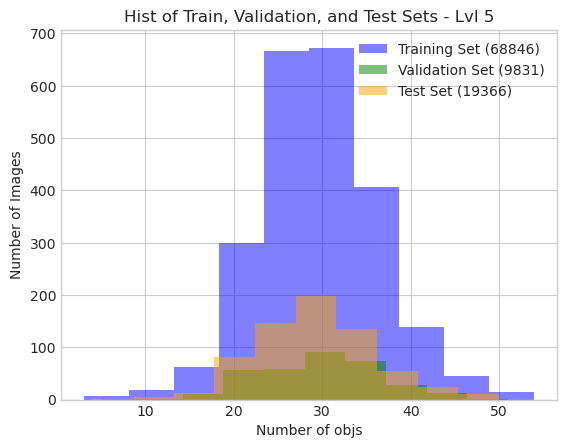

In [53]:
train_objs = [len(d['annotations']) for d in train_data]
val_objs = [len(d['annotations']) for d in val_data]
test_objs = [len(d['annotations']) for d in test_data]

plt.hist(train_objs, bins=10, color='blue', alpha=0.5, label=f'Training Set ({sum(train_objs)})')
plt.hist(val_objs, bins=10, color='green', alpha=0.5, label=f'Validation Set ({sum(val_objs)})')
plt.hist(test_objs, bins=10, color='orange', alpha=0.5, label=f'Test Set ({sum(test_objs)})')
plt.xlabel('Number of objs')
plt.ylabel('Number of Images')
plt.title(f'Hist of Train, Validation, and Test Sets - Lvl {snr_lvl}')
plt.legend()
print(f"Total Num of Annotated Objects in our data: {sum(train_objs) + sum(val_objs) + sum(test_objs)}")

## Mag *i* Distributions

In [91]:
# extract mag data by object type
def extract_mag(data, band='i'):
    mag = 'mag_'+band
    stars_mags, galaxies_mags, all_mags = [], [], []
    for anns in (d['annotations'] for d in data):
        for ann in anns:
            val = ann[mag]
            all_mags.append(val)
            (galaxies_mags if ann['category_id'] == 0 else stars_mags).append(val)
    
    return stars_mags, galaxies_mags, all_mags

def plot_hist(ax, data, bins, color, label, title):
    """
    Plots a histogram on a given Axes object and adds vertical lines for mean and max magnitudes
    Args:
        ax (matplotlib.axes.Axes): The axes object to plot on
        data (list): data to plot
        bins (np.array): bins for histogram
        color (str): Color of histogram
        label (str): Label for data 
        title (str): Title for subplot
    """
    ax.hist(data, bins=bins, color=color, alpha=0.8, label=label)  
    if data:
        mean_val = np.mean(data)
        max_val = np.max(data)
        ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        ax.axvline(max_val, color='red', linestyle='--', linewidth=2, label=f'Max: {max_val:.2f}')
    
    ax.set_xlabel(r'mag $i$')
    ax.set_ylabel('Number of Objs')
    if title:
        ax.set_title(title)
    ax.legend(frameon=True)
#     ax.grid(axis='y', alpha=0.5)

In [66]:
train_stars_i, train_galaxies_i, train_mags_i = extract_mag(train_data)
val_stars_i, val_galaxies_i, val_mags_i = extract_mag(val_data)
test_stars_i, test_galaxies_i, test_mags_i = extract_mag(test_data)

# combined datasets for overall distribution
all_stars_i = train_stars_i + val_stars_i + test_stars_i
all_galaxies_i = train_galaxies_i + val_galaxies_i + test_galaxies_i
all_mags_i = train_mags_i + val_mags_i + test_mags_i

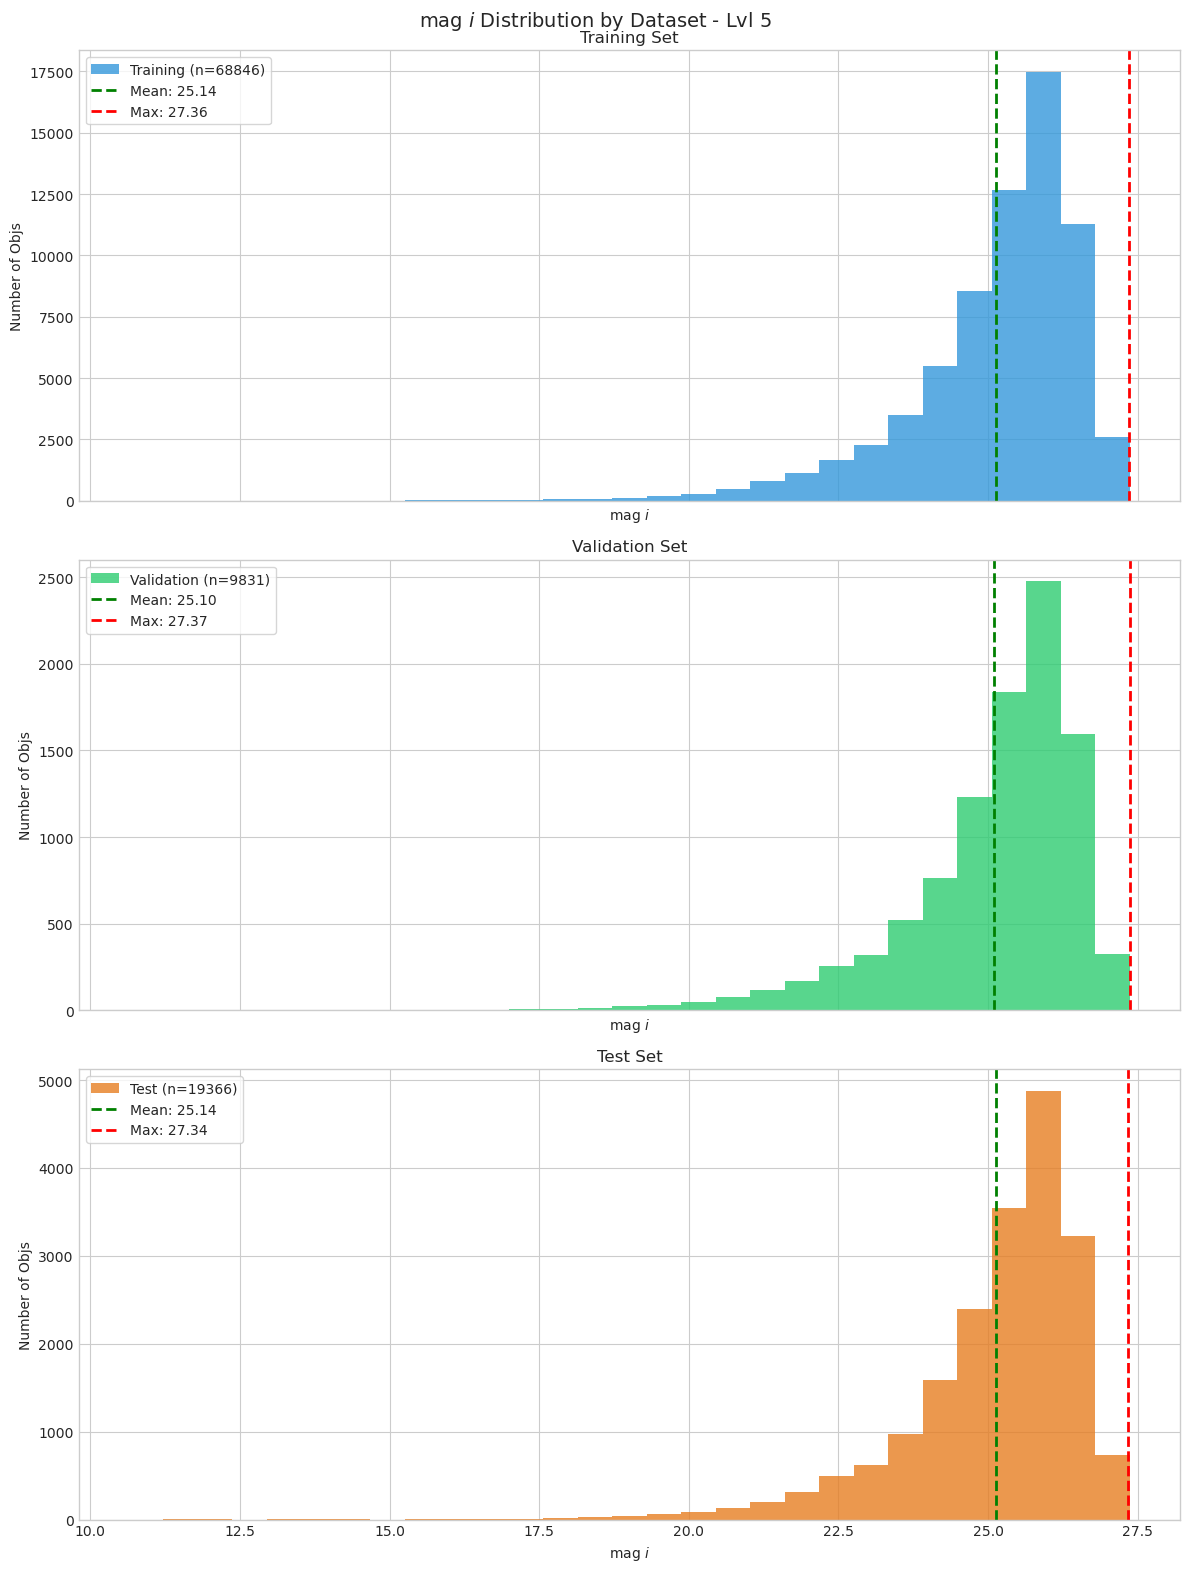

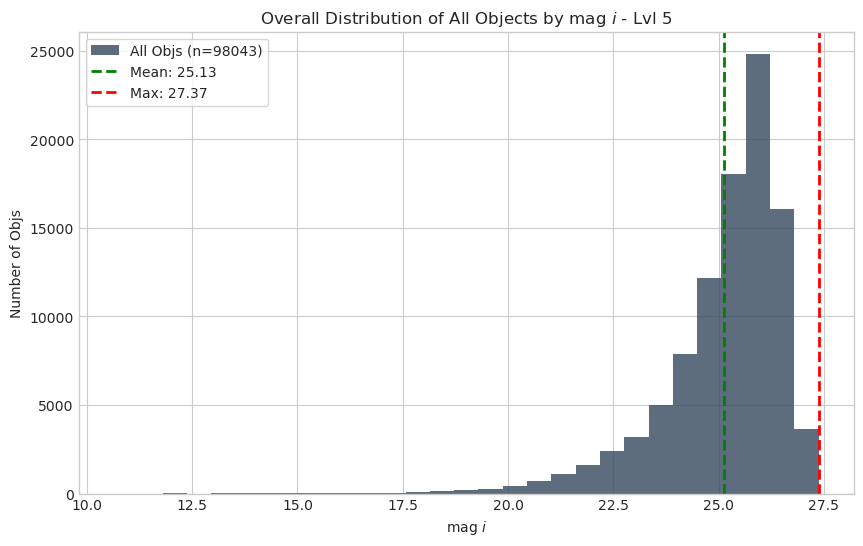

In [104]:
colors = {
    'train': '#3498db',  # blue
    'val': '#2ecc71',    # green
    'test': '#e67e22',   # orange
    'stars': '#e74c3c',  # red
    'galaxies': '#00008B',  # dark blue
    'all': '#34495e'     # Dark Gray
}

bins = np.linspace(min(all_mags_i), max(all_mags_i), 30)
# mag i Distribution for train, val, test
fig1, axs1 = plt.subplots(3, 1, figsize=(12, 16), sharex=True)
fig1.suptitle(r'mag $i$ Distribution by Dataset' + f' - Lvl {snr_lvl}', fontsize=14)

plot_data_1 = {
    'Training': (train_mags_i, colors['train']),
    'Validation': (val_mags_i, colors['val']),
    'Test': (test_mags_i, colors['test'])
}

for i, (split_name, (data, color)) in enumerate(plot_data_1.items()):
    plot_hist(axs1[i], data, bins=bins, color=color, label=f'{split_name} (n={len(data)})', title=f'{split_name} Set')
    
fig1.tight_layout()

# Distribution of All Objs by mag i
fig2, ax2 = plt.subplots(figsize=(10, 6))
title = r'Overall Distribution of All Objects by mag $i$' + f' - Lvl {snr_lvl}'
plot_hist(ax2, all_mags_i, bins=bins, color=colors['all'], label=f'All Objs (n={len(all_mags_i)})', title=title)

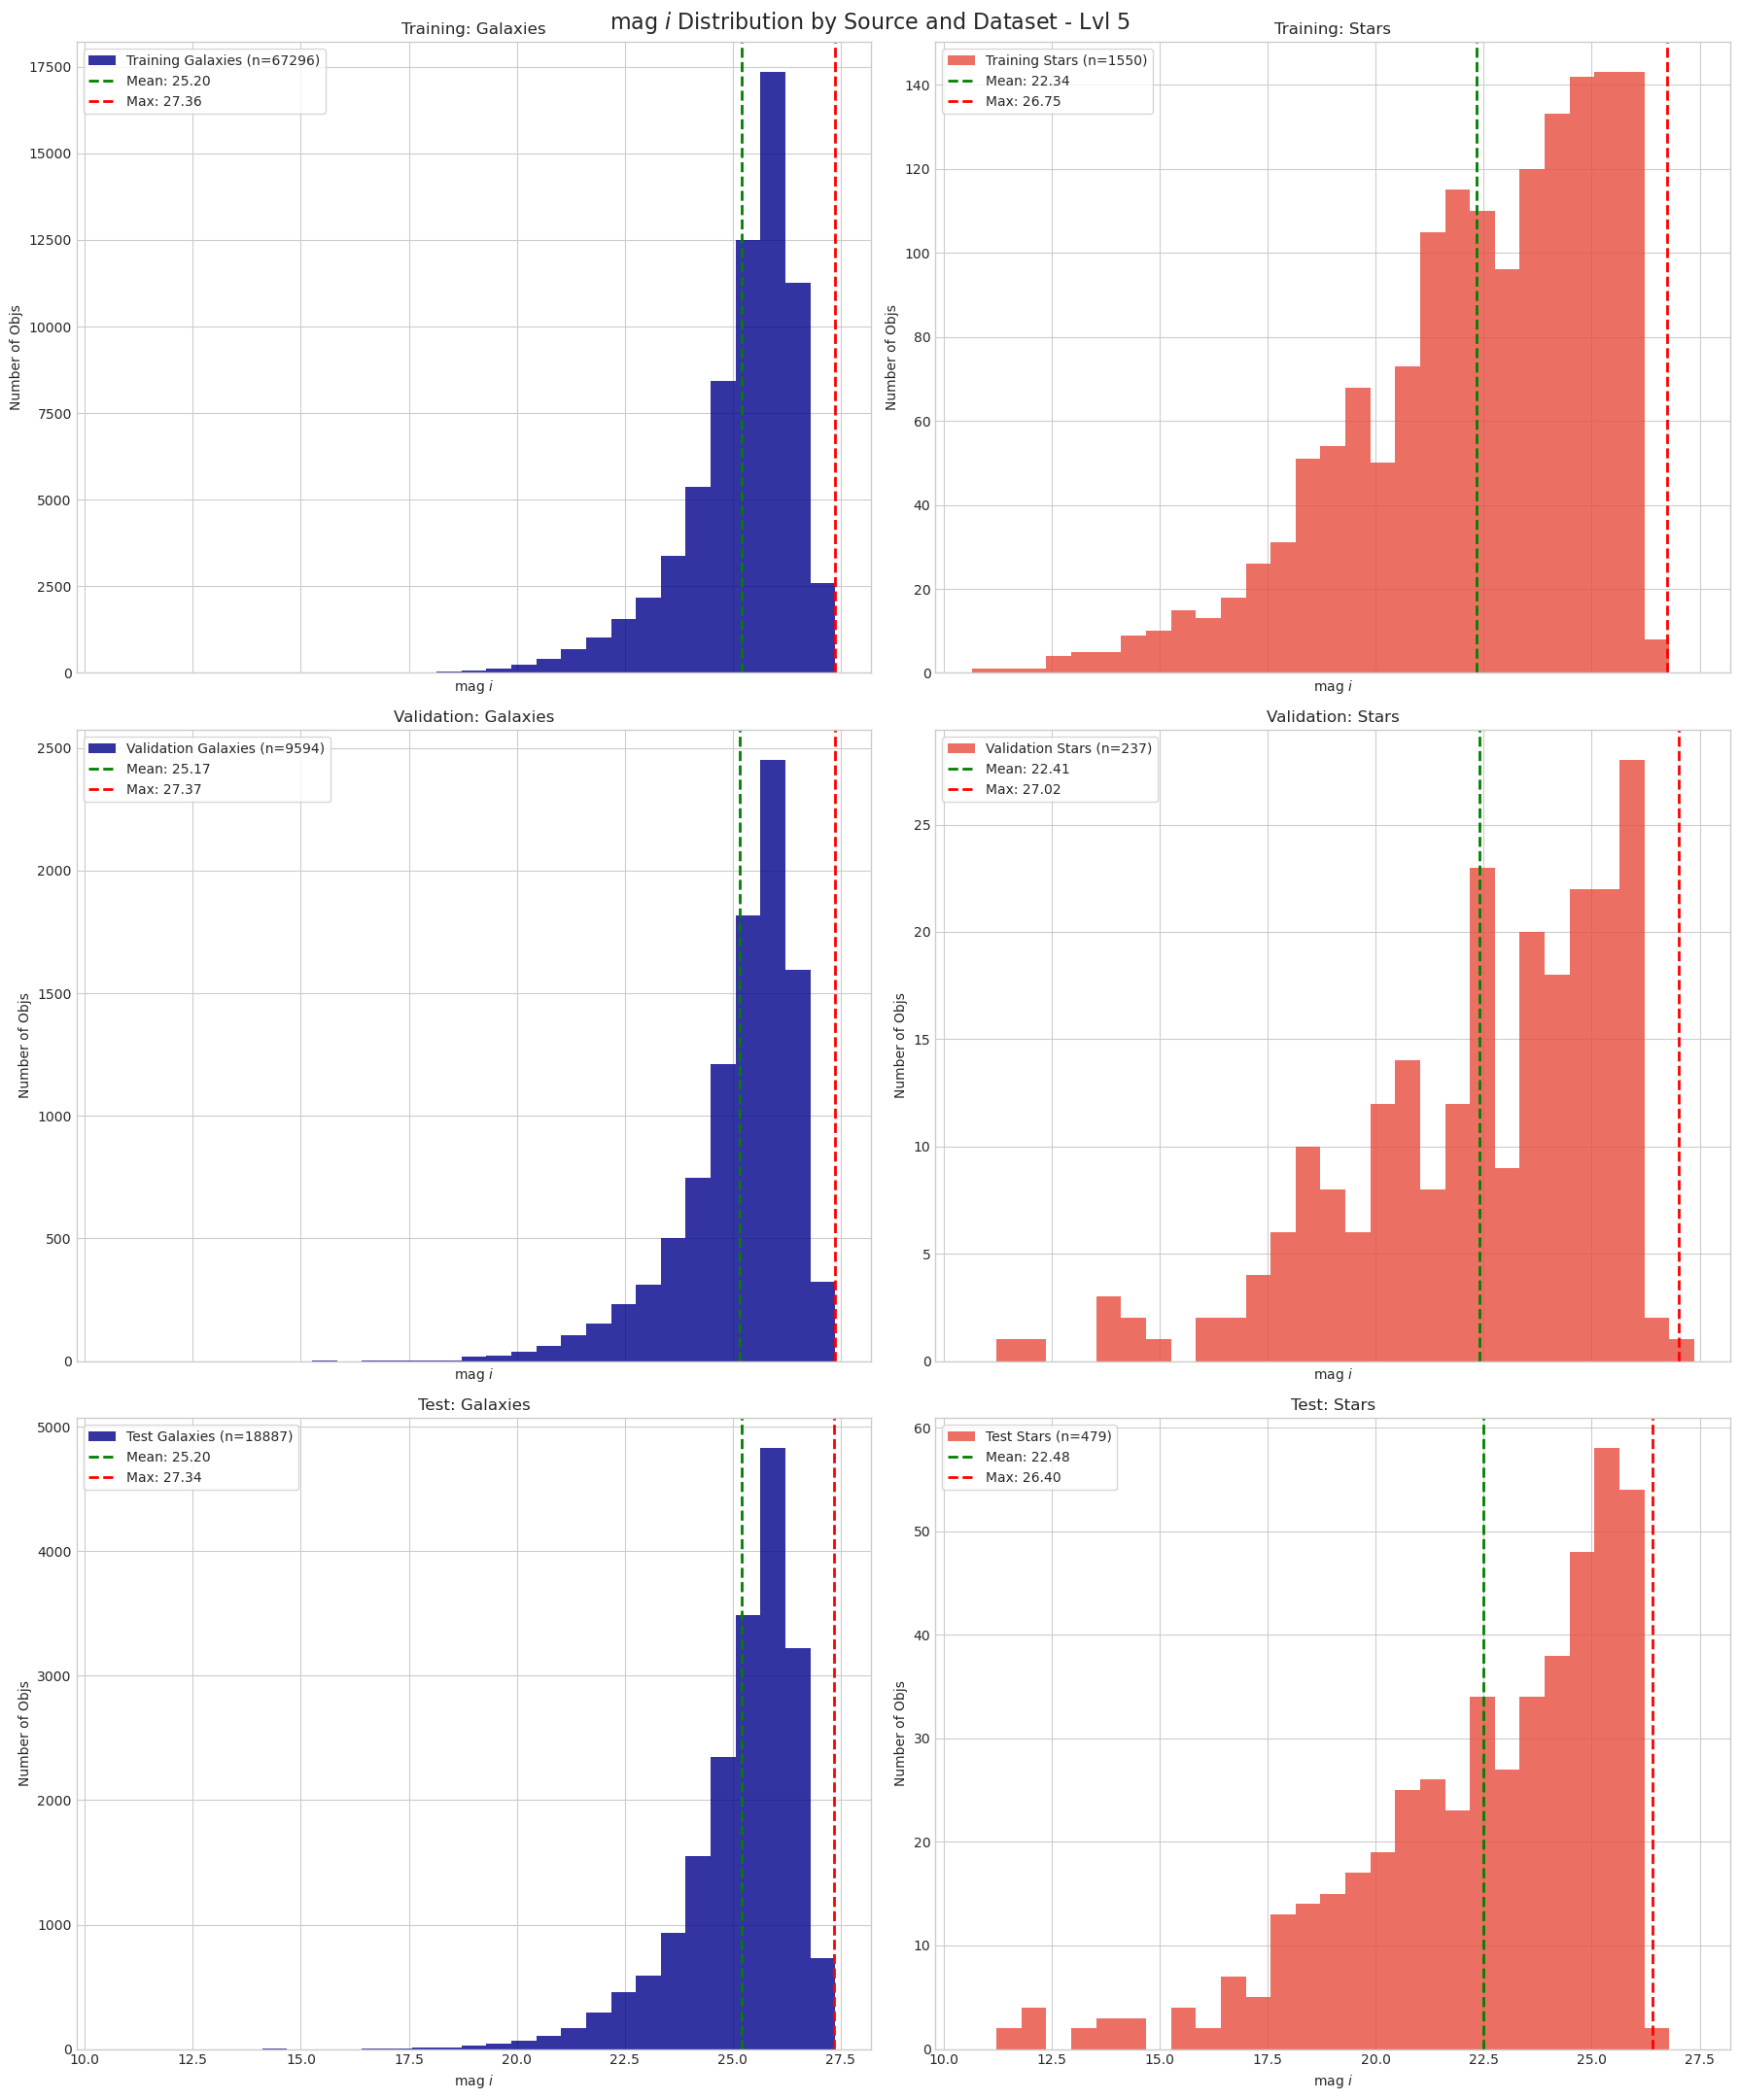

In [103]:
# galaxy and star mag i distribution (3 rows, 2 columns)
fig3, axs3 = plt.subplots(3, 2, figsize=(18, 22), sharex=True)
fig3.suptitle(r'mag $i$ Distribution by Source and Dataset' + f' - Lvl {snr_lvl}', fontsize=16)

plot_data_2 = {
    'Training': (train_galaxies_i, train_stars_i),
    'Validation': (val_galaxies_i, val_stars_i),
    'Test': (test_galaxies_i, test_stars_i)
}

for i, (split_name, (gal_data, star_data)) in enumerate(plot_data_2.items()):
    plot_hist(axs3[i, 0], gal_data, bins=bins, color=colors['galaxies'], label=f'{split_name} Galaxies (n={len(gal_data)})', title=f'{split_name}: Galaxies')
    plot_hist(axs3[i, 1], star_data, bins=bins, color=colors['stars'], label=f'{split_name} Stars (n={len(star_data)})', title=f'{split_name}: Stars')

fig3.tight_layout()